# Monto Estimado

(Escribir conexto****)

#### Librerias y conexión

Librerias

In [1]:
# Importacion de librerias
# Conexión a la base de datos
# ==========================================
import os
import sys
import pathlib

sys.path.append(
    os.path.join(pathlib.Path(os.getcwd()).parent)
)

from utils.bq_conn import bq_conn_file

bq_client = bq_conn_file(project_id="dsa-miad-365616")

# Tratamiento de datos
# ==========================================
import pandas as pd
import numpy as np
from datetime import datetime

# Graficas
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import seaborn as sns

# Transformación de las Variables y Modelos ML
# ==========================================
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

Consulta SQL.

In [2]:
query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''

In [3]:
secop_I = bq_client.execute_query(query=query)
print(f"El número de filas del dataset es de: {secop_I.shape[0]}\nEl número de columnas del dataset es de: {secop_I.shape[1]}")
secop_I.head(5)

El número de filas del dataset es de: 26553
El número de columnas del dataset es de: 38


,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,...,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,...,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,...,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,...,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,...,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,...,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


#### Eliminación de columnas irrelevantes

In [4]:
# eliminación de variables con información poco relevante de acuerdo con el análisis exploratorio
secop_I_filter = secop_I.drop(['anno_cargue_secop', 'plazo_de_ejec_del_contrato_', 'cuantia_contrato',
                                'uid', 'modalidad_de_contratacion', 'municipio_de_obtencion', 'municipios_ejecucion_',
                                'numero_de_proceso', 'numero_de_contrato', 'nombre_grupo', 'id_familia', 
                                'nombre_familia', 'id_clase', 'nombre_clase', 'id_adjudicacion', 'tipo_identifi_del_contratista',
                                'tipo_identifi_del_contratista', 'identificacion_del_contratista', 'nom_razon_social_contratista',
                                'tipo_doc_representante_legal', 'identific_representante_legal',
                                'rango_de_ejec_del_contrato', 'moneda', 'objeto_del_contrato_a_la',
                                'ruta_proceso_en_secop_i', 'prorrogado', 'con_adicion_pptal'], axis=1)
secop_I_filter.columns

Index(['id_modalidad', 'estado_del_proceso', 'id_objeto_a_contratar',
       'detalle_del_objeto_a_contratar', 'tipo_de_contrato',
       'departamento_ejecucion', 'cuantia_proceso', 'id_grupo',
       'dias_ejec_final_contrato', 'tiempo_adiciones_en_dias',
       'valor_total_de_adiciones', 'valor_contrato_con_adiciones'],
      dtype='object')

#### Casteo de las variables

In [5]:
# casteo de las variables
secop_I_filter['id_modalidad'] = secop_I_filter['id_modalidad'].astype('category')
secop_I_filter['estado_del_proceso'] = secop_I_filter['estado_del_proceso'].astype('category')
secop_I_filter['id_objeto_a_contratar'] = secop_I_filter['id_objeto_a_contratar'].astype('category')
secop_I_filter['tipo_de_contrato'] = secop_I_filter['tipo_de_contrato'].astype('category')
secop_I_filter['departamento_ejecucion'] = secop_I_filter['departamento_ejecucion'].astype('category')
secop_I_filter['cuantia_proceso'] = secop_I_filter['cuantia_proceso'].astype('int')
secop_I_filter['id_grupo'] = secop_I_filter['id_grupo'].astype('category')
secop_I_filter['dias_ejec_final_contrato'] = secop_I_filter['dias_ejec_final_contrato'].astype('int')
secop_I_filter['tiempo_adiciones_en_dias'] = secop_I_filter['tiempo_adiciones_en_dias'].astype('int')
secop_I_filter['valor_total_de_adiciones'] = secop_I_filter['valor_total_de_adiciones'].astype('int')
secop_I_filter['valor_contrato_con_adiciones'] = secop_I_filter['valor_contrato_con_adiciones'].astype('int')

In [6]:
secop_I_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26553 entries, 0 to 26552
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id_modalidad                    26553 non-null  category
 1   estado_del_proceso              26553 non-null  category
 2   id_objeto_a_contratar           26553 non-null  category
 3   detalle_del_objeto_a_contratar  26553 non-null  object  
 4   tipo_de_contrato                26553 non-null  category
 5   departamento_ejecucion          26553 non-null  category
 6   cuantia_proceso                 26553 non-null  int32   
 7   id_grupo                        26553 non-null  category
 8   dias_ejec_final_contrato        26553 non-null  int32   
 9   tiempo_adiciones_en_dias        26553 non-null  int32   
 10  valor_total_de_adiciones        26553 non-null  int32   
 11  valor_contrato_con_adiciones    26553 non-null  int32   
dtypes: category(6), in

#### Preprocesamiento

##### Eliminación de outliers

In [7]:
# Dimensiones del dataset
# ==============================================================================
secop_I.shape

(26553, 38)

In [8]:
# Tratamiento de outliers valor_contrato_con_adiciones
Q1 = np.percentile(secop_I_filter['valor_contrato_con_adiciones'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(secop_I_filter['valor_contrato_con_adiciones'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", secop_I_filter.shape)
 
# Upper bound
upper = Q3+1.5*IQR
upper_array = secop_I_filter.loc[secop_I_filter['valor_contrato_con_adiciones']>=upper].index.to_list()

# Lower bound
lower = Q1-1.5*IQR
lower_array = secop_I_filter.loc[secop_I_filter['valor_contrato_con_adiciones']<=lower].index.to_list()

# Removing the outliers
secop_I_filter.drop(upper_array, inplace=True)
secop_I_filter.drop(lower_array, inplace=True)
secop_I_filter.reset_index(drop=True, inplace=True)
 
print("New Shape: ", secop_I_filter.shape)

Old Shape:  (26553, 12)
New Shape:  (23054, 12)


C:\Users\Majo\AppData\Local\Temp\ipykernel_5612\154439062.py:2: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(secop_I_filter['valor_contrato_con_adiciones'], 25,
C:\Users\Majo\AppData\Local\Temp\ipykernel_5612\154439062.py:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(secop_I_filter['valor_contrato_con_adiciones'], 75,


In [9]:
# Tratamiento de outliers dias_ejec_final_contrato
Q1 = np.percentile(secop_I_filter['dias_ejec_final_contrato'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(secop_I_filter['dias_ejec_final_contrato'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", secop_I_filter.shape)
 
# Upper bound
upper = Q3+1.5*IQR
upper_array = secop_I_filter.loc[secop_I_filter['dias_ejec_final_contrato']>=upper].index.to_list()

# Lower bound
lower = Q1-1.5*IQR
lower_array = secop_I_filter.loc[secop_I_filter['dias_ejec_final_contrato']<=lower].index.to_list()

# Removing the outliers
secop_I_filter.drop(upper_array, inplace=True)
secop_I_filter.drop(lower_array, inplace=True)
secop_I_filter.reset_index(drop=True, inplace=True)
 
print("New Shape: ", secop_I_filter.shape)

Old Shape:  (23054, 12)
New Shape:  (20476, 12)


C:\Users\Majo\AppData\Local\Temp\ipykernel_5612\582161890.py:2: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(secop_I_filter['dias_ejec_final_contrato'], 25,
C:\Users\Majo\AppData\Local\Temp\ipykernel_5612\582161890.py:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(secop_I_filter['dias_ejec_final_contrato'], 75,


##### Transformación y normalización

In [10]:
num_col = secop_I_filter.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_col = secop_I_filter.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
num_trans = Pipeline(steps=[('imputer', 
                             SimpleImputer(strategy='median')), 
                             ('scaler', StandardScaler())])

# Transformaciones para las variables categóricas
cat_trans = Pipeline(steps=[('imputer', 
                             SimpleImputer(strategy='most_frequent')), 
                             ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', num_trans, num_col),
                        ('cat', cat_trans, cat_col)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out=False
               ).set_output(transform="pandas")

data_prep = preprocessor.fit_transform(secop_I_filter)

In [11]:
data_prep.head(5)

,cuantia_proceso,dias_ejec_final_contrato,tiempo_adiciones_en_dias,valor_total_de_adiciones,valor_contrato_con_adiciones,id_modalidad_1,id_modalidad_9,id_modalidad_11,id_modalidad_12,id_modalidad_13,...,departamento_ejecucion_sucre,departamento_ejecucion_tolima,departamento_ejecucion_valle del cauca,id_grupo_A,id_grupo_B,id_grupo_C,id_grupo_D,id_grupo_E,id_grupo_F,id_grupo_G
0,0.403782,2.838902,-0.095322,-0.172521,2.312432,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.697326,1.141443,-0.095322,-0.172521,3.432237,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.050953,0.920993,-0.095322,-0.172521,0.577724,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.121394,0.413960,-0.095322,-0.172521,0.309007,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.286477,3.059351,-0.095322,-0.172521,-0.320746,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Conjunto de datos en *train* y *test*

Se particiona el conjunto de datos dos subconjuntos de datos, train que es el conjunto de datos utilizados para entrenar los modelos el cual representa el 80% de los datos totales y test para comprobar el rendimiento de los modelos que representa el 20% restante.

In [12]:
# conjunto de datos train
data_train = data_prep.sample(frac=0.9, random_state=0)

# conjunto de datos test
data_test = data_prep.drop(data_train.index)

#### Modelos de Regresión

In [13]:
# import pycaret regression and init setup
from pycaret.regression import *
s = setup(data_train, 
          target='valor_contrato_con_adiciones', 
          feature_selection=True, 
          fold=5, train_size= 0.8,
          preprocess=True,
          session_id=123)
models()

,Description,Value
0,Session id,123
1,Target,valor_contrato_con_adiciones
2,Target type,Regression
3,Original data shape,"(18428, 16145)"
4,Transformed data shape,"(18428, 3229)"
5,Transformed train set shape,"(14742, 3229)"
6,Transformed test set shape,"(3686, 3229)"
7,Numeric features,16144
8,Preprocess,True
9,Imputation type,simple


,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [14]:
# compare models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.1748,0.1824,0.4269,0.8185,0.1665,1.7669,2.8720
rf,Random Forest Regressor,0.1638,0.1941,0.4403,0.8068,0.1703,1.4422,9.6060
gbr,Gradient Boosting Regressor,0.2046,0.2066,0.4544,0.7943,0.1706,1.9217,8.2620
et,Extra Trees Regressor,0.1702,0.2183,0.4669,0.7827,0.1750,1.4332,17.0580
dt,Decision Tree Regressor,0.1833,0.2791,0.5281,0.7219,0.1961,1.5222,4.1300
ada,AdaBoost Regressor,0.3823,0.3501,0.5912,0.6516,0.2448,3.2459,10.6360
knn,K Neighbors Regressor,0.4207,0.4885,0.6989,0.5134,0.2925,2.3521,4.9560
br,Bayesian Ridge,0.5595,0.6797,0.8242,0.3236,0.3595,4.6190,11.9380
ridge,Ridge Regression,0.5570,0.6815,0.8252,0.3218,0.3576,4.8413,5.5360
omp,Orthogonal Matching Pursuit,0.5500,0.6925,0.8317,0.3110,0.3593,4.6272,3.8680


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [21]:
type(best)

lightgbm.sklearn.LGBMRegressor

#### Análisis del mejor modelo

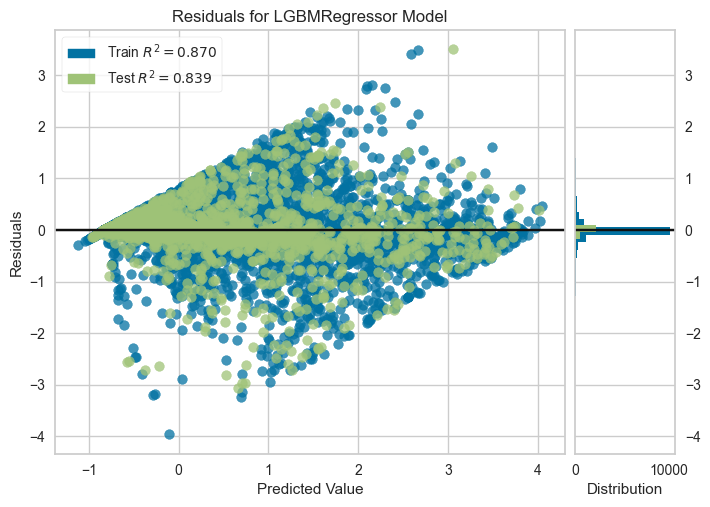

In [15]:
# plot residuals
plot_model(best, plot='residuals')

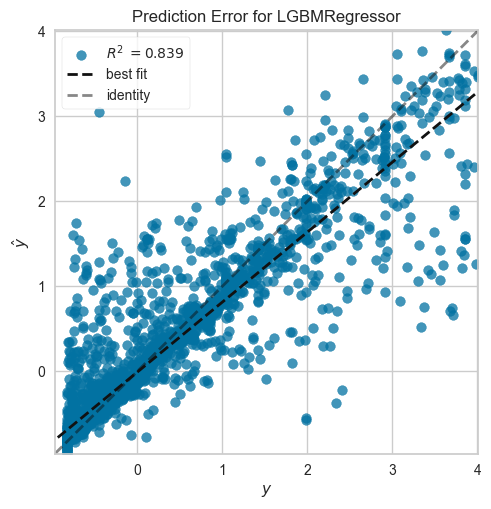

In [16]:
# plot error
plot_model(best, plot='error')

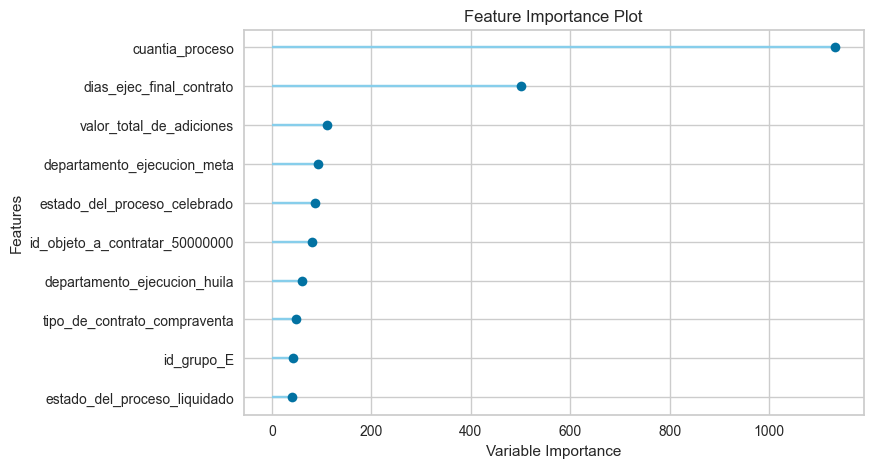

In [18]:
# plot feature
plot_model(best, plot='feature')

In [20]:
# plot parameter
plot_model(best, plot='parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


#### Optimización del modelo

In [22]:
# tune model con choose_better
tuned_best_model = tune_model(best, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1991,0.1935,0.4398,0.8048,0.1651,1.1897
1,0.1944,0.1799,0.4242,0.8198,0.1562,2.1140
2,0.2071,0.2086,0.4567,0.7878,0.1786,1.2730
3,0.2046,0.2083,0.4564,0.7937,0.1736,2.0359
4,0.1959,0.2083,0.4564,0.7996,0.1715,4.0933
Mean,0.2002,0.1997,0.4467,0.8011,0.1690,2.1412
Std,0.0049,0.0115,0.0130,0.0109,0.0077,1.0471


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [24]:
# tune model maximizando el R2
r2_tuned = tune_model(best, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1991,0.1935,0.4398,0.8048,0.1651,1.1897
1,0.1944,0.1799,0.4242,0.8198,0.1562,2.1140
2,0.2071,0.2086,0.4567,0.7878,0.1786,1.2730
3,0.2046,0.2083,0.4564,0.7937,0.1736,2.0359
4,0.1959,0.2083,0.4564,0.7996,0.1715,4.0933
Mean,0.2002,0.1997,0.4467,0.8011,0.1690,2.1412
Std,0.0049,0.0115,0.0130,0.0109,0.0077,1.0471


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [30]:
# tune model con n_estimadores
ensemble_tuned = ensemble_model(best, n_estimators=100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1757,0.1810,0.4254,0.8174,0.1632,1.0536
1,0.1660,0.1642,0.4052,0.8356,0.1540,1.1262
2,0.1723,0.1756,0.4191,0.8214,0.1687,0.9035
3,0.1750,0.1843,0.4293,0.8175,0.1652,1.4062
4,0.1728,0.1917,0.4378,0.8155,0.1723,4.0046
Mean,0.1724,0.1793,0.4234,0.8215,0.1647,1.6988
Std,0.0034,0.0092,0.0109,0.0073,0.0062,1.1644


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

#### Análisis del mejor modelo despues del tuned

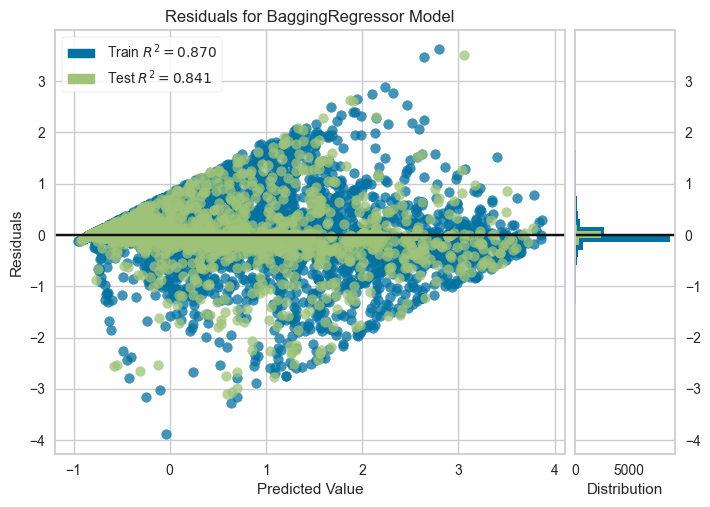

In [31]:
# plot residuals
plot_model(ensemble_tuned, plot='residuals')

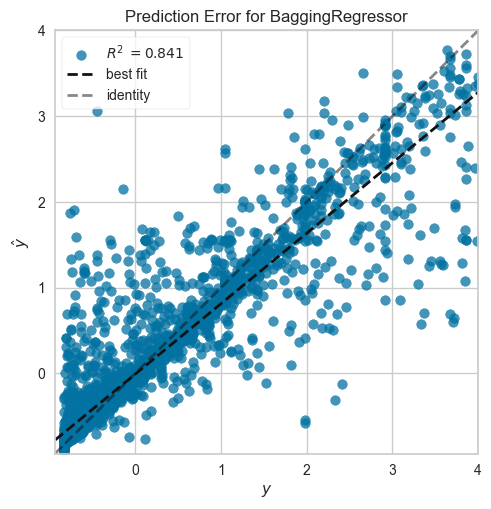

In [32]:
# plot error
plot_model(ensemble_tuned, plot='error')

In [35]:
# plot feature
#plot_model(ensemble_tuned, plot='feature')

In [45]:
# interpretación del modelo
interpret_model(ensemble_tuned)

ModuleNotFoundError: 
'shap' is a soft dependency and not included in the pycaret installation. Please run: `pip install shap` to install.
Alternately, you can install this by running `pip install pycaret[analysis]`

In [44]:
!pip install shap to install

  Using cached shap-0.41.0-cp310-cp310-win_amd64.whl (435 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for to: filename=to-0.3-py3-none-any.whl size=33540 sha256=3d82788ebf351a0021a440221b54f8149e0a0057fba27b42727417d51e8580ca
  Stored in directory: c:\users\majo\appdata\local\pip\cache\wheels\80\de\db\6607e08c6a5a25c17fe73e7d7444aa59789070babcd21f6566
Successfully built to
